In [1]:
#!conda env list

## 1 Set API Key

In [1]:
import os
from openai import OpenAI 

## Set the API key and model name
MODEL="gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")
client = OpenAI(api_key=api_key)

### 1.1 Try out functionality

In [2]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "user", "content": "You are a helpful recruiting assistant. We have a list of candidates we want to interview for a job and we want to tailor interview questions to their skills."}, # <-- This is the system message that provides context to the model
    {"role": "system", "content": f"Hello! Based on the following candidates:, could you make a list of 5 interview questions for all of them based on their total pool of skills and how it relates to the skills required of the job - here:  "}  # <-- This is the user message for which the model will generate a response
  ]
)

In [3]:
from IPython.display import display, Markdown, Latex
display(Markdown(completion.choices[0].message.content))

Of course! However, you'll need to provide me with the candidates' names and their respective skills, as well as the job title and required skills for the position. Once I have that information, I can create tailored interview questions for each candidate.

### 1.2 Create Dataframe with Job Descriptions

In [4]:
ls

LICENSE                      main.py
LLM.ipynb                    model_improvements.ipynb
README.md                    resumes/
Resources/                   services/
__pycache__/                 source/
agenda.md                    synthetic_data.ipynb
comparison.ipynb             synthetic_data_binary.ipynb
environment.yml              user_interface/
environment_mac.yml          word_embeddings.ipynb
job_descriptions/


In [5]:
import os
import pandas as pd

job_descriptions_path = 'job_descriptions/'
files = [f for f in os.listdir(job_descriptions_path) if f.endswith('.txt')]
jobs = []

for i, filename in enumerate(files):
    with open(os.path.join(job_descriptions_path, filename), 'r', encoding='utf-8') as f:
        content = f.read().strip()
        
        # If the Job Title is the first line of the file
        lines = content.split('\n')
        job_title = lines[0]  # Assuming the first line is the Job Title
        jd = '\n'.join(lines[1:])  # The rest is the Job Description
        
        # If the Job Title is derived from the filename instead, uncomment the next line
        # job_title = os.path.splitext(filename)[0]  # Filename without extension
        
        jobs.append({
            'Job ID': i + 1,
            'Job Title': job_title,
            'JD': jd
        })

df_jobs = pd.DataFrame(jobs)
df_jobs

,Job ID,Job Title,JD
0,1,,
1,2,,
2,3,,
3,4,,
4,5,,
5,6,"Machine Learning Engineer, Sage, London",\nFull job description\n\nAbout our Team:\nThe...
6,7,,
7,8,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
8,9,Data Scientist,Lisbon\n\n\n\nApply on employer site\n\n\nAppl...
9,10,Junior Data Engineer,"At Capgemini Engineering, the world leader in ..."


In [6]:
job_titles_to_keep = [
    'Senior Data Scientist, WTW, London',
    'Software Engineer II, Android, Microsoft, London'
]

df_filtered = df_jobs[df_jobs['Job Title'].isin(job_titles_to_keep)].reset_index(drop=True)
df_filtered['Job ID'] = df_filtered.index + 1
df_filtered

,Job ID,Job Title,JD
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
1,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...


## 2 Binary

### New Approach for Creating Synthetic Data with Clear Skill Match Separation

#### Goal
The goal is to create a synthetic dataset that generates three resumes per job description (JD) with a perfect to very good fit to the skills mentioned in the JD. Additionally, in a separate API call, three resumes will be generated for each job description that have a poor skill match to the JD.

#### Approach

1. **Creating Resumes with Good Fit:**
    - For each job description, three resumes will be generated.
    - These resumes should have a perfect to very good fit to the skills mentioned in the JD.
    - These resumes will be created in the first API call.

2. **Creating Resumes with Poor Fit:**
    - For each job description, three additional resumes will be generated.
    - These resumes should have a poor skill match to the JD, meaning they contain irrelevant skills that do not align or relate to the skills mentioned in the JD.
    - These resumes will be created in a second, separate API call.

#### Next Steps
In the next step, we will create the code to implement this approach. The code will:
- Iterate through the job descriptions.
- Generate three resumes with a good fit for each job description.
- Generate three resumes with a poor fit for each job description.
- Store and display the generated resumes in a DataFrame.

This approach aims to ensure that the generated resumes have clearly distinguishable skill matches, providing a better foundation for further analysis.

### 2.1 First try - binary approach (3 good, 3 bad fit resumes)

#### 2.1.1 Good fit resumes 

In [7]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **2 = Very Good Fit** (very good alignment of skills and related skills between resume and job description).
- **3 = Good Fit** (good alignment of skills and related skills between resume and job description).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,**Resume: John Smith** \n[Email: john.smith@e...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,**Candidate Resume**\n\n**Name:** John Doe \n...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,**Candidate Name:** John Smith \n**Location:*...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Resume for Candidate: Alex Johnson**\n\n**Co...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,**Candidate Name:** Alex Johnson \n**Email:**...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,**Candidate Name:** Alice Thompson \n**Email:...,3


In [8]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_5_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.1.2 Bad fit resumes

In [9]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Poor Fit** (poor alignment of skills and related skills between resume and job description).
- **2 = Very Poor Fit** (very poor alignment of skills and related skills between resume and job description).
- **3 = No Fit** (no alignment of skills and related skills between resume and job description - the candidate comes from another field entirely, such as marketing or finance).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Candidate Resume: John Smith**\n\n**Contact ...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,**Candidate Name:** David Thompson \n**Contac...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume for Candidate A**\n\n**Name:** John S...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Candidate Name:** Sarah Thompson \n**Locati...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume: John Smith** \n[Phone: (555) 123-45...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Candidate Resume: John Doe**\n\n**Contact In...,3


In [10]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_5_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


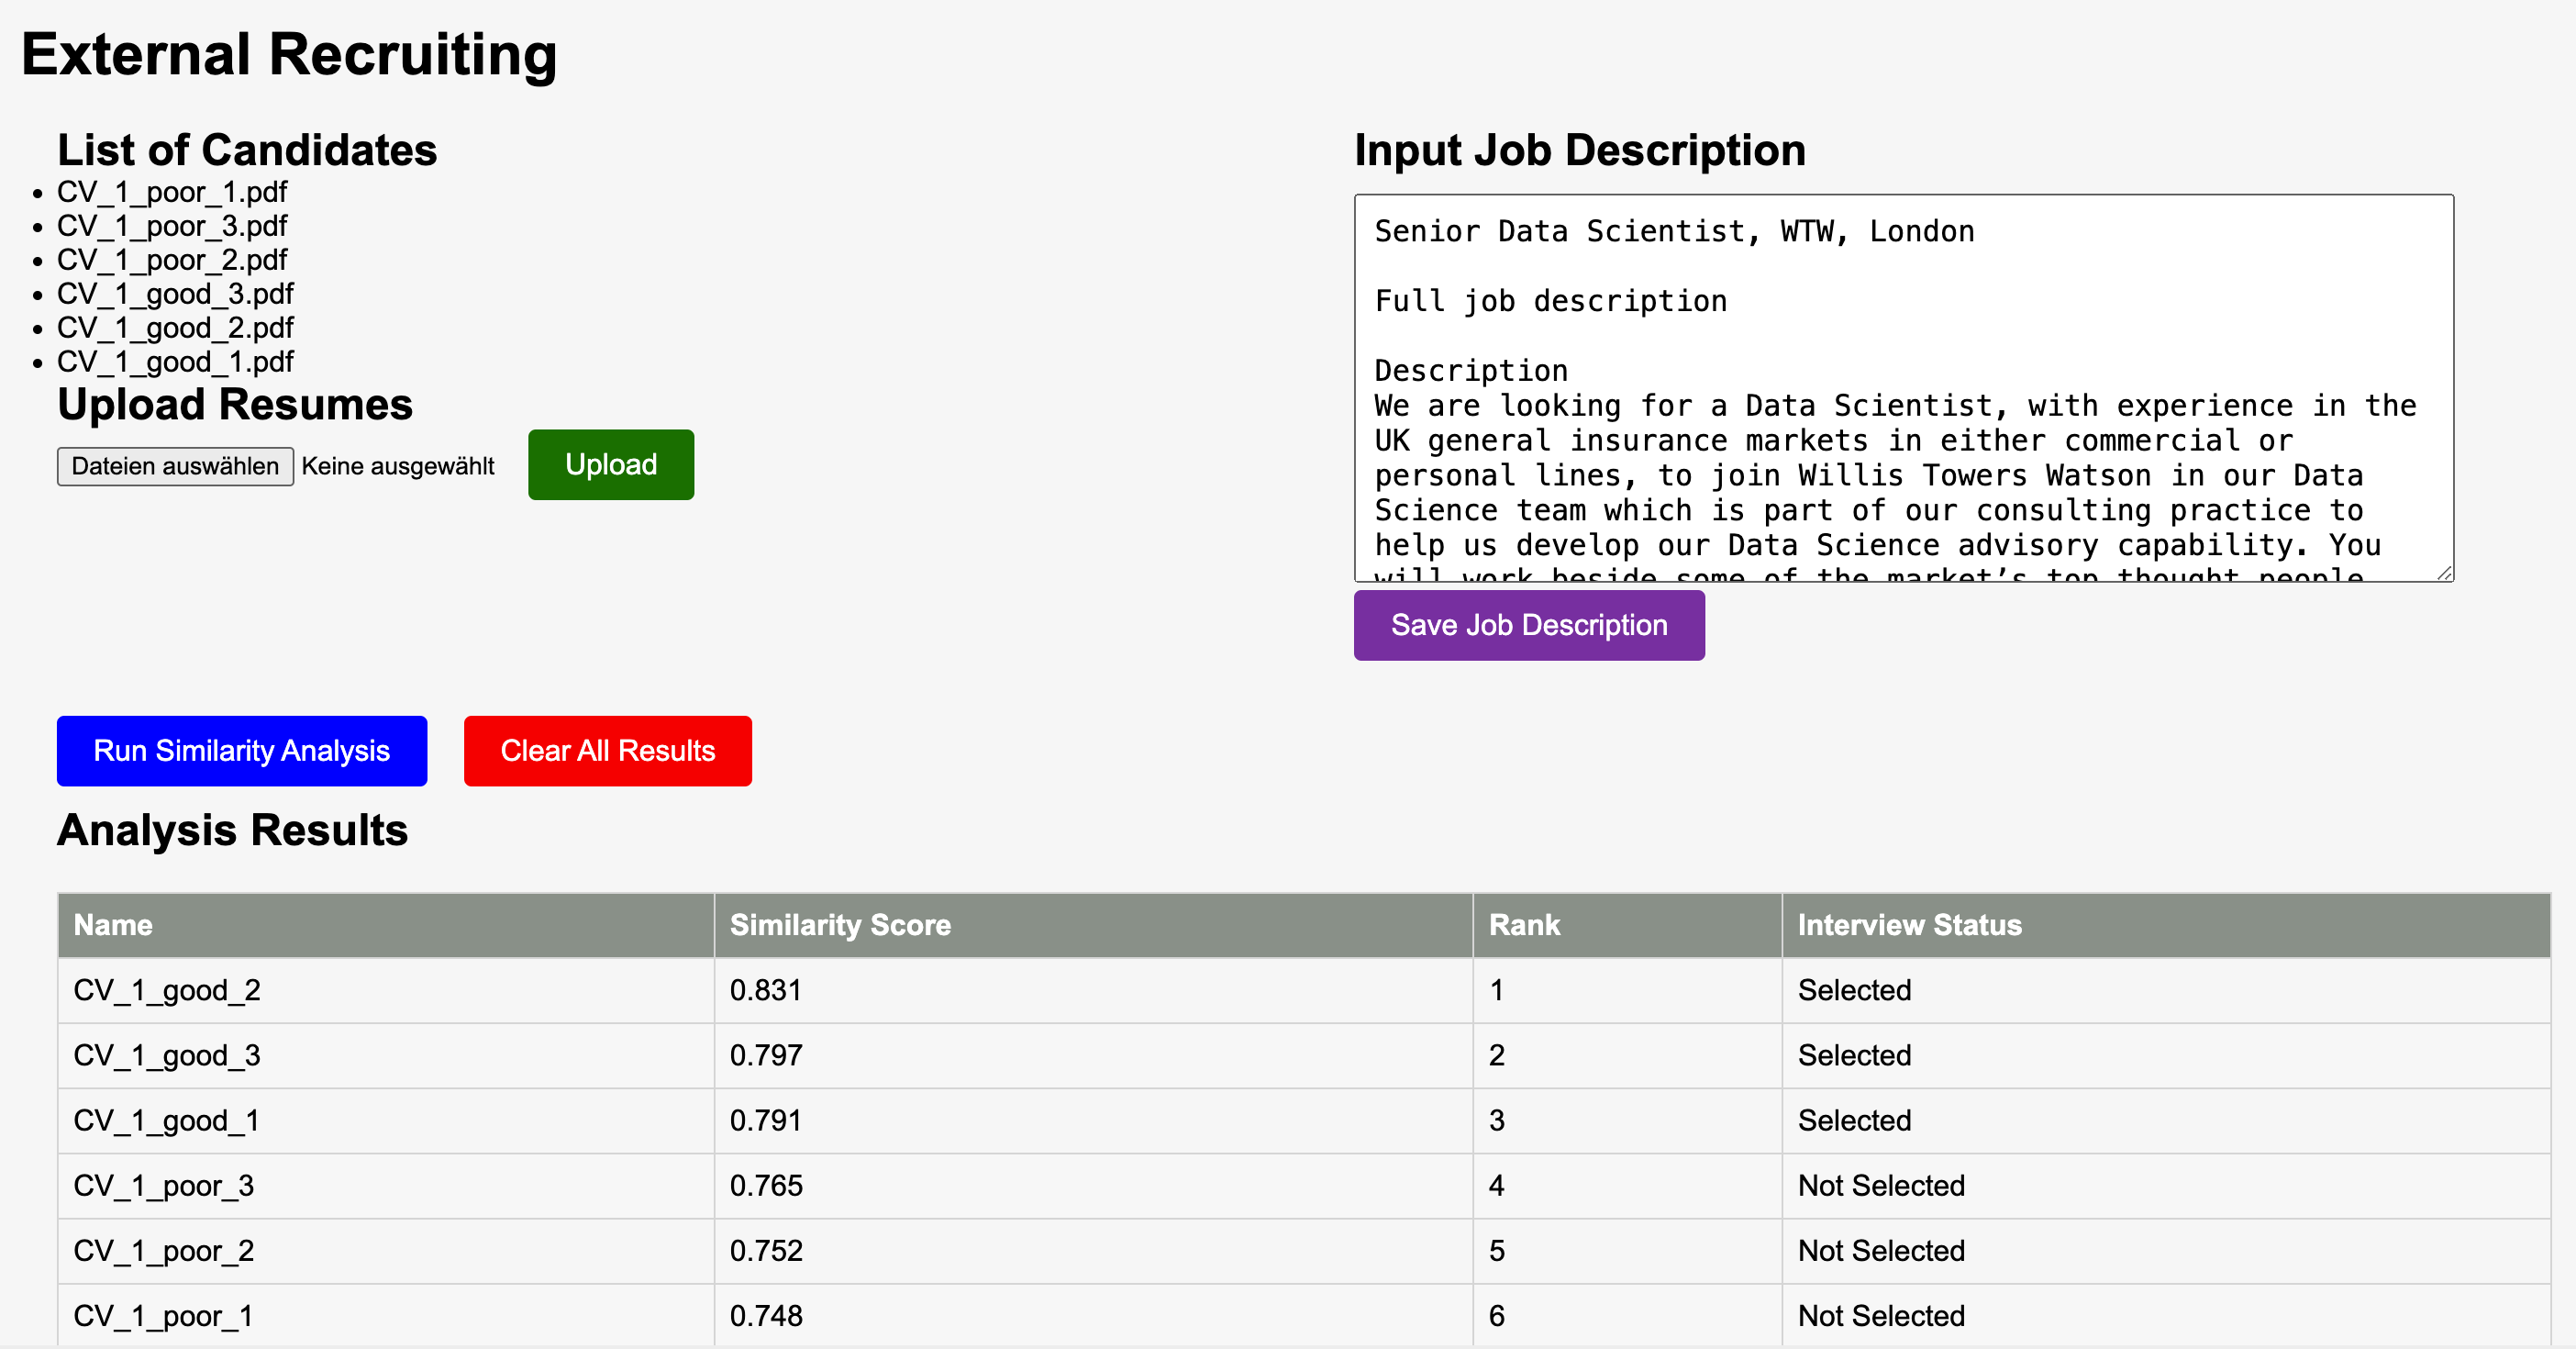

### 2.2 Second Try - Adjusted promt *and explanation*: Just almost perfect an very bad matches, no ranking

#### 2.2.1 Good fit resumes

In [11]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
At the end of the resume, include an explanation of how you generated the resumes in order to achive a high fit with the job description.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,"**John Doe** \nLondon, UK \nEmail: johndoe@e...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,**Candidate Name:** Emma Johnson \n**Contact ...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,**Candidate Name:** Elizabeth Stone \n**Locat...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Resume of Emily Carter** \n[Your Phone Numb...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,"**John Doe** \nLondon, UK \nEmail: john.doe@...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,**Resume**\n\n**Alice Thompson** \n[Your Addr...,3


In [12]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_6_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.2.2 Bad fit resumes

In [13]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
At the end of the resume, include an explanation of how you generated the resumes in order to achive a bad fit with the job description.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Candidate Name:** Alex Johnson \n**Address:...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,**Resume** \n---\n\n**Johnathan D. Fields** ...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume for Maxine Robinson**\n\n---\n\n**Max...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Resume: Lisa Tran**\n\n**Contact Information...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume**\n\n**Name:** Jane Doe \n**Address:...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Resume**\n\n**Name:** Amir Johnson \n**Addr...,3


In [14]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_6_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


### 2.3 Third Try - Adjusted promt *without explanation*: Just almost perfect an very bad matches, no ranking

#### 2.3.1 Good fit resumes

In [15]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,"**John Smith** \n[Your Address] \n[City, Zip...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,"**John Smith** \n[London, UK] \n[Email: john...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,"**John Smith**\nLondon, UK \nEmail: john.smit...",3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Jane Doe** \n[Email: jane.doe@example.com] ...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,"**John Doe** \n123 Tech Way, London, UK \njo...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,"**Resume**\n\n**John Smith** \nLondon, UK \n...",3


In [16]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_7_binary_no_explanation"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.3.2 Bad fit resumes

In [17]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Johnathan Smith** \n123 Technology Lane \n...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,"**John Doe** \n123 Main St, Anytown, UK \njo...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume**\n\n**Jane Doe** \n123 Coastal Rd ...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Resume**\n\n**James Smithson** \nEmail: jam...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume: Jordan Smith** \n[Email: jordansmit...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Resume: Marcus Albright**\n\n**Contact Infor...,3


In [18]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_7_binary_no_explanation"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

### 2.4 Fourth Try - Adjusted promt *without explanation*: Just almost perfect an slightly bad matches, no ranking

#### 2.4.1 Good fit resumes

In [26]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,11,Candidate_1_good_1,"**John Smith** \n123 Data Lane \nLondon, UK ...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,12,Candidate_1_good_2,"**John Doe** \n[Your Address] \n[City, Postc...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,13,Candidate_1_good_3,"**Jane Doe** \n[Your Address] \nLondon, UK ...",3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,21,Candidate_2_good_1,"**John Anderson** \nLondon, UK \njohn.anders...",1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,22,Candidate_2_good_2,"**Resume**\n\n**Alex Thompson** \nLondon, UK ...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,23,Candidate_2_good_3,"**Resume**\n\n**John Anderson** \nLondon, UK ...",3


In [22]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data binary/Test_4_slightly_bad"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.4.2 Slightly bad fit resumes

In [25]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an slightly bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is slighly bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,14,Candidate_1_poor_4,"**Alexandra Thompson** \nLondon, UK \nalexan...",4
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,15,Candidate_1_poor_5,"**Johnathan Smith** \nLondon, UK \n+44 20 79...",5
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,16,Candidate_1_poor_6,**Johnathan Smith** \n123 Elm Street \nLondo...,6
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,24,Candidate_2_poor_4,"**Alex Johnson** \n123 Main Street \nLondon,...",4
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,25,Candidate_2_poor_5,"**John Doe** \n123 Tech Lane \nLondon, UK \...",5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,26,Candidate_2_poor_6,"**John Smith** \n123 Tech Lane \nLondon, UK ...",6


In [24]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data binary/Test_4_slightly_bad"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

### 2.4.3 Merging the datasets

In [29]:
import pandas as pd

# Merge the DataFrames
df_synthetic_resumes = pd.concat([df_resumes_good_fit, df_resumes_poor_fit], ignore_index=True)

# Sort the DataFrame based on 'CV ID' in descending order
df_synthetic_resumes_sorted = df_synthetic_resumes.sort_values(by='CV ID', ascending=True).reset_index(drop=True)

# Display the combined and sorted DataFrame
df_synthetic_resumes_sorted

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,11,Candidate_1_good_1,"**John Smith** \n123 Data Lane \nLondon, UK ...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,12,Candidate_1_good_2,"**John Doe** \n[Your Address] \n[City, Postc...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,13,Candidate_1_good_3,"**Jane Doe** \n[Your Address] \nLondon, UK ...",3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,14,Candidate_1_poor_4,"**Alexandra Thompson** \nLondon, UK \nalexan...",4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,15,Candidate_1_poor_5,"**Johnathan Smith** \nLondon, UK \n+44 20 79...",5
5,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,16,Candidate_1_poor_6,**Johnathan Smith** \n123 Elm Street \nLondo...,6
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,21,Candidate_2_good_1,"**John Anderson** \nLondon, UK \njohn.anders...",1
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,22,Candidate_2_good_2,"**Resume**\n\n**Alex Thompson** \nLondon, UK ...",2
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,23,Candidate_2_good_3,"**Resume**\n\n**John Anderson** \nLondon, UK ...",3
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,24,Candidate_2_poor_4,"**Alex Johnson** \n123 Main Street \nLondon,...",4


### 3 LinkedIn tech job descriptions dataset

#### 3.1 Import and random subset (with Dask)

In [83]:
import dask.dataframe as dd

file_path = '/Users/timg/Downloads/jobs.csv'

# Specify the data type for the 'date' column
dtype = {'date': 'object'}

# Read the CSV file using Dask with specified dtype
df_job_descriptions_linkedin = dd.read_csv(file_path, dtype=dtype)

# Compute the number of columns
num_columns = len(df_job_descriptions_linkedin.columns)
print(f'Number of columns: {num_columns}')

# Compute the number of rows
num_rows = df_job_descriptions_linkedin.shape[0].compute()
print(f'Number of rows: {num_rows}')

Number of columns: 18
Number of rows: 8261


In [84]:
df_job_descriptions_linkedin.head()

,Employment type,Industries,Job function,Seniority level,company,company_id,context,date,description,education,location,months_experience,post_id,post_url,sal_high,sal_low,salary,title
0,Full-time,Broadcast Media,Information Technology,Mid-Senior level,CyberCoders,21836.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Job Title: Senior Data Engineer Location: Alex...,bachelor degree,"Alexandria, VA",60.0,2632814552,https://www.linkedin.com/jobs/view/senior-data...,NaN,NaN,NaN,Senior Data Engineer
1,Full-time,"Hospital & Health Care, Medical Devices, and P...",Engineering and Information Technology,Not Applicable,Johnson & Johnson,1207.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,"Ethicon, part of Johnson & Johnson Medical Dev...",bachelor degree,"Santa Clara, CA",96.0,2632810866,https://www.linkedin.com/jobs/view/principal-f...,NaN,NaN,NaN,Principal Full Stack Software Engineer.
2,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Washington, DC",84.0,2632812746,https://www.linkedin.com/jobs/view/senior-soft...,189000.0,120000.0,"$120,000.00/yr - $189,000.00/yr",Senior Software Engineer
3,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Reston, VA",84.0,2632817427,https://www.linkedin.com/jobs/view/senior-soft...,189000.0,120000.0,"$120,000.00/yr - $189,000.00/yr",Senior Software Engineer
4,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Irving, TX",84.0,2632817426,https://www.linkedin.com/jobs/view/senior-soft...,175000.0,108000.0,"$108,000.00/yr - $175,000.00/yr",Senior Software Engineer


In [85]:
print(df_job_descriptions_linkedin.columns.tolist())

['Employment type', 'Industries', 'Job function', 'Seniority level', 'company', 'company_id', 'context', 'date', 'description', 'education', 'location', 'months_experience', 'post_id', 'post_url', 'sal_high', 'sal_low', 'salary', 'title']


/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2699030505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_descriptions_linkedin_date['year'] = df_job_descriptions_linkedin_date['date'].dt.year
/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2699030505.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette='viridis')


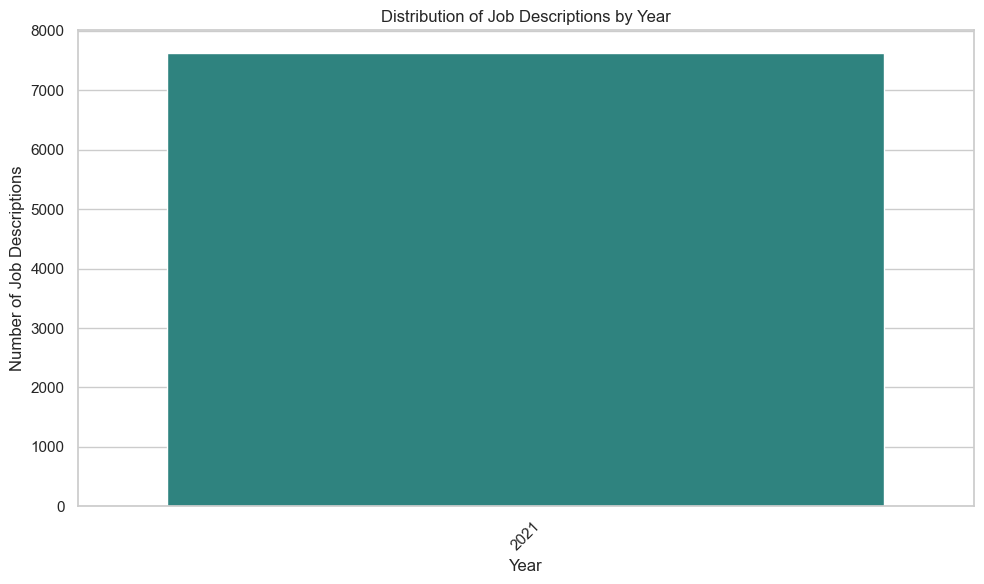

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df_job_descriptions_linkedin = df_job_descriptions_linkedin.compute()

# Step 1: Convert 'date' column to datetime format if it's not already
df_job_descriptions_linkedin['date'] = pd.to_datetime(df_job_descriptions_linkedin['date'], errors='coerce')

# Handle any NaT values (if any dates couldn't be parsed)
df_job_descriptions_linkedin_date = df_job_descriptions_linkedin.dropna(subset=['date'])

# Step 2: Extract the year from the 'date' column and create a new column 'year'
df_job_descriptions_linkedin_date['year'] = df_job_descriptions_linkedin_date['date'].dt.year

# Step 3: Calculate the count of job descriptions per year
year_counts = df_job_descriptions_linkedin_date['year'].value_counts().sort_index()

# Step 4: Plot the distribution of job descriptions by year
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette='viridis')
plt.title('Distribution of Job Descriptions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Job Descriptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Columns in df_sample:
Index(['Employment type', 'Industries', 'Job function', 'Seniority level',
       'company', 'company_id', 'context', 'date', 'description', 'education',
       'location', 'months_experience', 'post_id', 'post_url', 'sal_high',
       'sal_low', 'salary', 'title'],
      dtype='object')


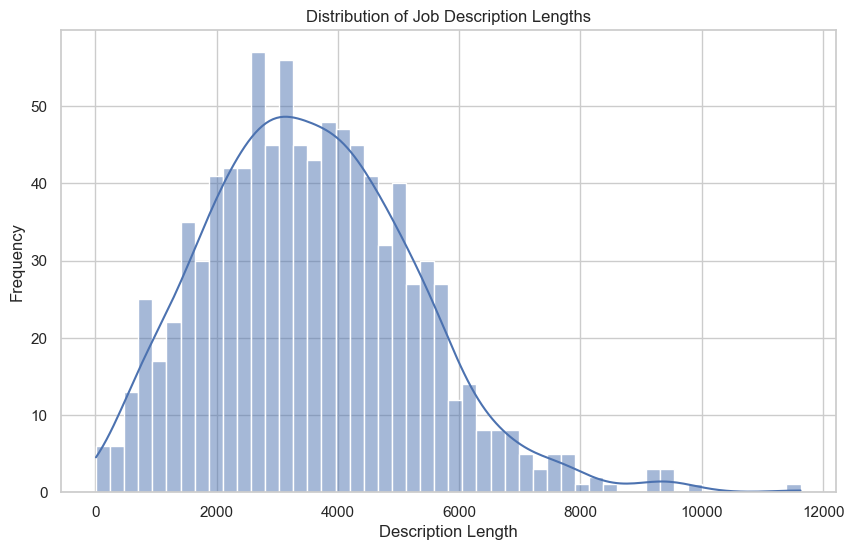

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Sample 1,000 random rows from the Dask DataFrame and convert to pandas DataFrame
total_rows = df_job_descriptions_linkedin.shape[0].compute()
frac = 1000 / total_rows
frac_adjusted = frac * 1.1  # Adjust as needed
df_sample_dd = df_job_descriptions_linkedin.sample(frac=frac_adjusted, random_state=42)
df_sample_pd = df_sample_dd.compute()
df_sample = df_sample_pd.sample(n=1000, random_state=42)

# Step 2: Check the column names
print("Columns in df_sample:")
print(df_sample.columns)

# Step 3: Add a column "description_length" to the pandas DataFrame
df_sample['description_length'] = df_sample['description'].str.len()

# Step 4: Create a plot showing the distribution of "description_length"
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['description_length'], bins=50, kde=True)
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [87]:
# Using the interquartile range (IQR) to get rid of outliers
Q1 = df_sample['description_length'].quantile(0.25)
Q3 = df_sample['description_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_sample[
    (df_sample['description_length'] >= lower_bound) &
    (df_sample['description_length'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_filtered = df_filtered.reset_index(drop=True)

In [88]:
# Step 1: Calculate mean and standard deviation
mean_length = df_filtered['description_length'].mean()
std_length = df_filtered['description_length'].std()

# Step 2: Determine the upper and lower bounds
lower_bound = mean_length - std_length
upper_bound = mean_length + std_length

# Step 3: Filter the DataFrame to keep rows within one standard deviation
df_filtered_2 = df_filtered[
    (df_filtered['description_length'] >= lower_bound) &
    (df_filtered['description_length'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_filtered_2 = df_filtered_2.reset_index(drop=True)

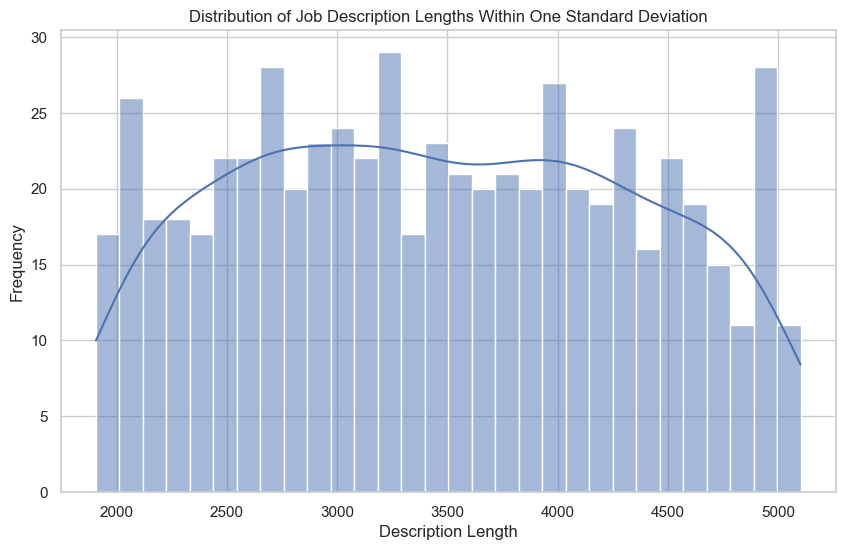

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_filtered_2['description_length'], bins=30, kde=True)
plt.title('Distribution of Job Description Lengths Within One Standard Deviation')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [90]:
num_rows_before = len(df_sample)
num_rows_after = len(df_filtered_2)
rows_dropped = num_rows_before - num_rows_after

print(f"Rows before filtering: {num_rows_before}")
print(f"Rows after filtering: {num_rows_after}")
print(f"Rows dropped: {rows_dropped}")

Rows before filtering: 1000
Rows after filtering: 620
Rows dropped: 380


#### 3.2 EDA

In [109]:
df_filtered_2.head(3)

,Job function,company,date,description,education,location,months_experience,sal_high,sal_low,title,description_length
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0


In [93]:
# List of columns to drop
columns_to_drop = [
    'Employment type', 'Industries', 'Seniority level', 'company_id', 'context', 'post_id', 'post_url', 'salary'
]

# Drop the specified columns
df_filtered_2 = df_filtered_2.drop(columns=columns_to_drop)

# Verify the columns have been dropped
print("Remaining columns in the dataset:")
print(df_filtered_2.columns)

Remaining columns in the dataset:
Index(['Job function', 'company', 'date', 'description', 'education',
       'location', 'months_experience', 'sal_high', 'sal_low', 'title',
       'description_length'],
      dtype='object')


In [110]:
df_filtered_2.head(3)

,Job function,company,date,description,education,location,months_experience,sal_high,sal_low,title,description_length
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0


In [95]:
# Set seaborn style for better visuals
sns.set(style='whitegrid')

In [96]:
# Display the shape of the dataset
print(f"Dataset Shape: {df_filtered_2.shape}")

# Display data types of each column
print("\nData Types:")
print(df_filtered_2.dtypes)

# Display first few rows
print("\nFirst 5 Rows:")
print(df_filtered_2.head())

Dataset Shape: (620, 11)

Data Types:
Job function           object
company                object
date                   object
description            object
education              object
location               object
months_experience     float64
sal_high              float64
sal_low               float64
title                  object
description_length    float64
dtype: object

First 5 Rows:
                                       Job function       company  \
0  Marketing, Public Relations, and Writing/Editing   Nepris Inc.   
1                                 Quality Assurance  Lucid Motors   
2            Engineering and Information Technology       Walmart   
3            Engineering and Information Technology      Assurant   
4            Engineering and Information Technology         Plaid   

                         date  \
0  2021-09-01 23:13:04.915228   
1  2021-07-29 22:22:13.068249   
2  2021-07-19 22:51:59.132023   
3  2021-07-29 22:03:36.459980   
4  2021-10-05 11:02:19.

In [97]:
# Check for missing values in each column
print("\nMissing Values in Each Column:")
print(df_filtered_2.isnull().sum())


Missing Values in Each Column:
Job function           28
company                 0
date                   47
description             0
education              17
location                0
months_experience     183
sal_high              437
sal_low               437
title                   0
description_length      0
dtype: int64


In [98]:
# Get summary statistics for numerical columns
print("\nStatistical Summary of Numerical Columns:")
print(df_filtered_2.describe())


Statistical Summary of Numerical Columns:
       months_experience       sal_high        sal_low  description_length
count         437.000000     183.000000     183.000000          620.000000
mean           47.917620  152345.879781   93299.377049         3457.638710
std            25.822837   39913.427332   25768.774319          887.554522
min            12.000000   60800.000000   42100.000000         1906.000000
25%            24.000000  122000.000000   74350.000000         2714.000000
50%            48.000000  149700.000000   88200.000000         3437.500000
75%            60.000000  180000.000000  113500.000000         4209.000000
max           144.000000  259900.000000  167000.000000         5102.000000


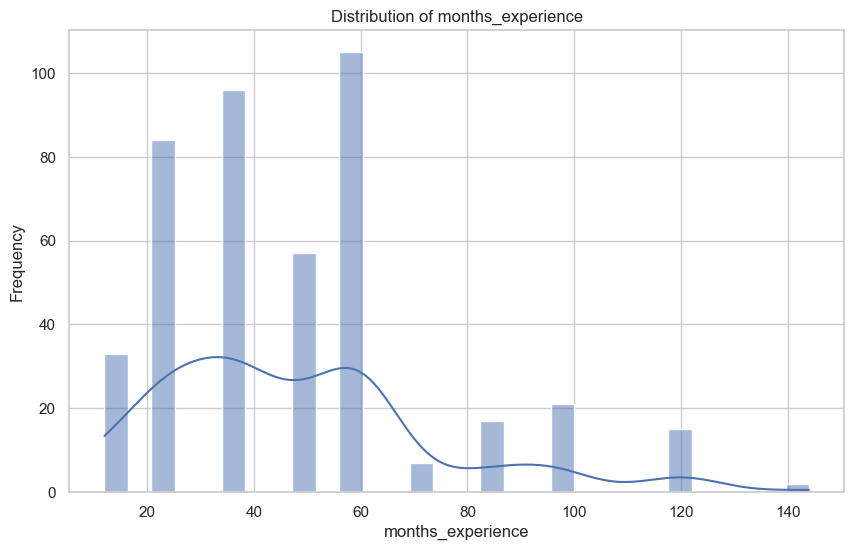

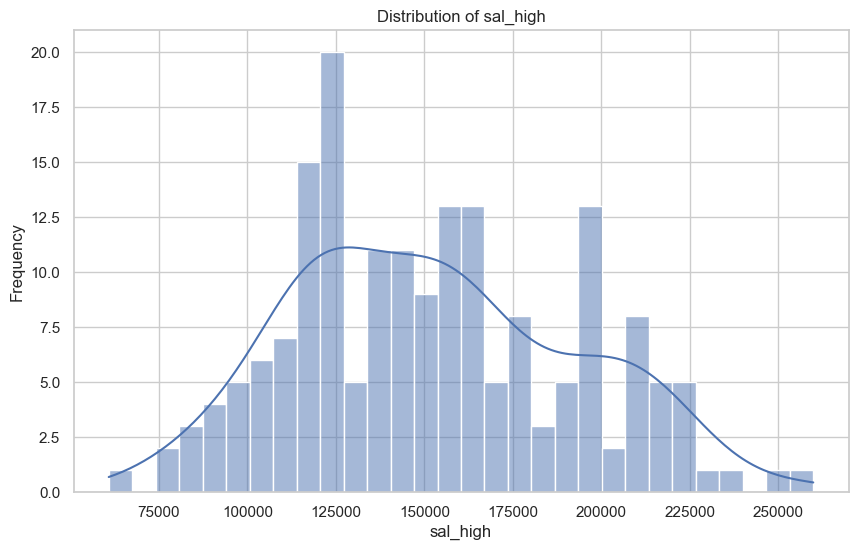

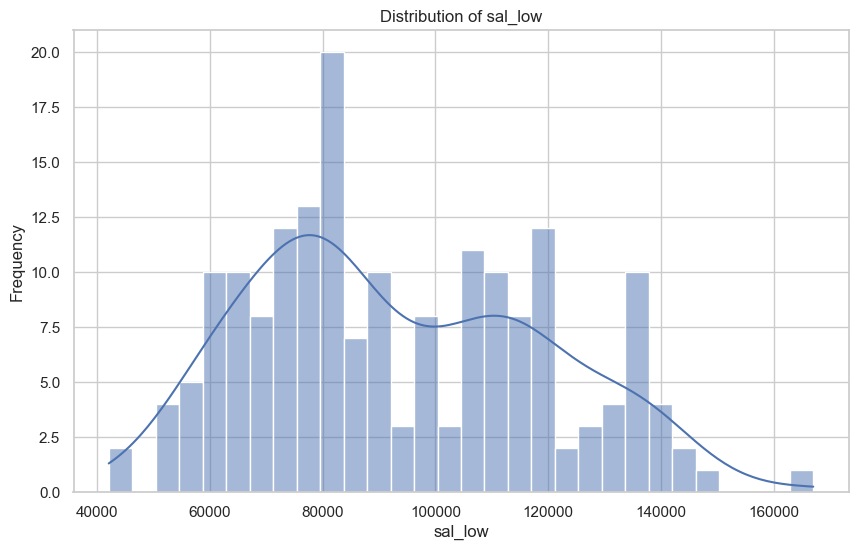

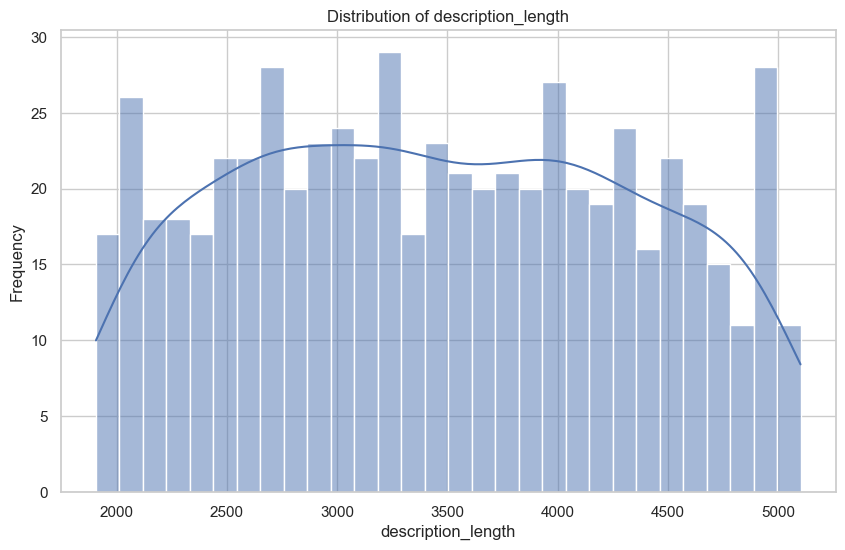

In [100]:
# Identify numerical columns
numerical_columns = df_filtered_2.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_filtered_2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


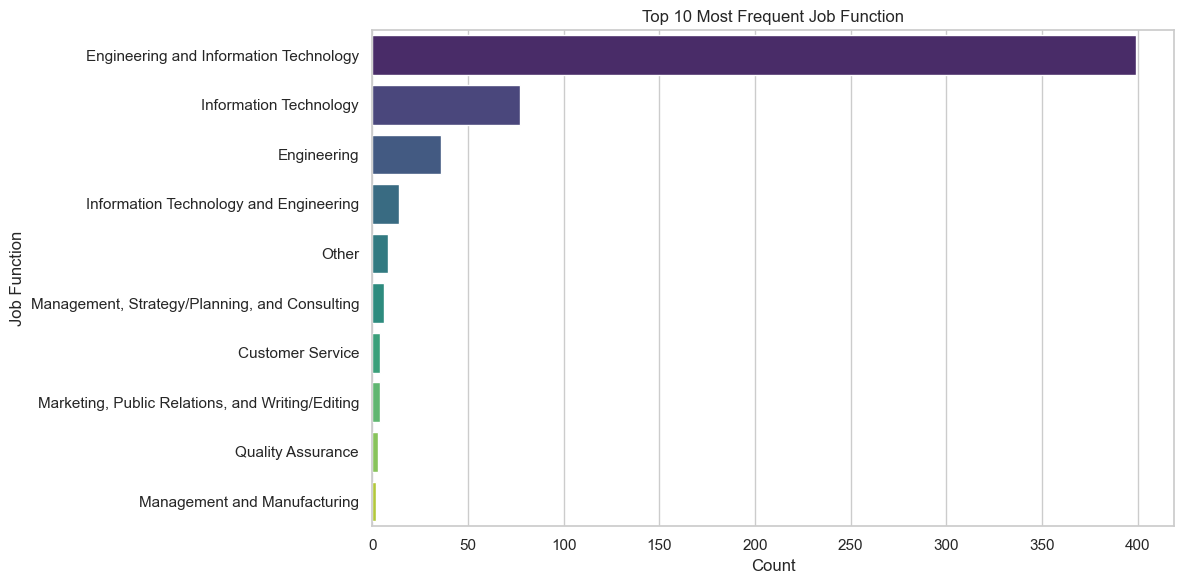

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


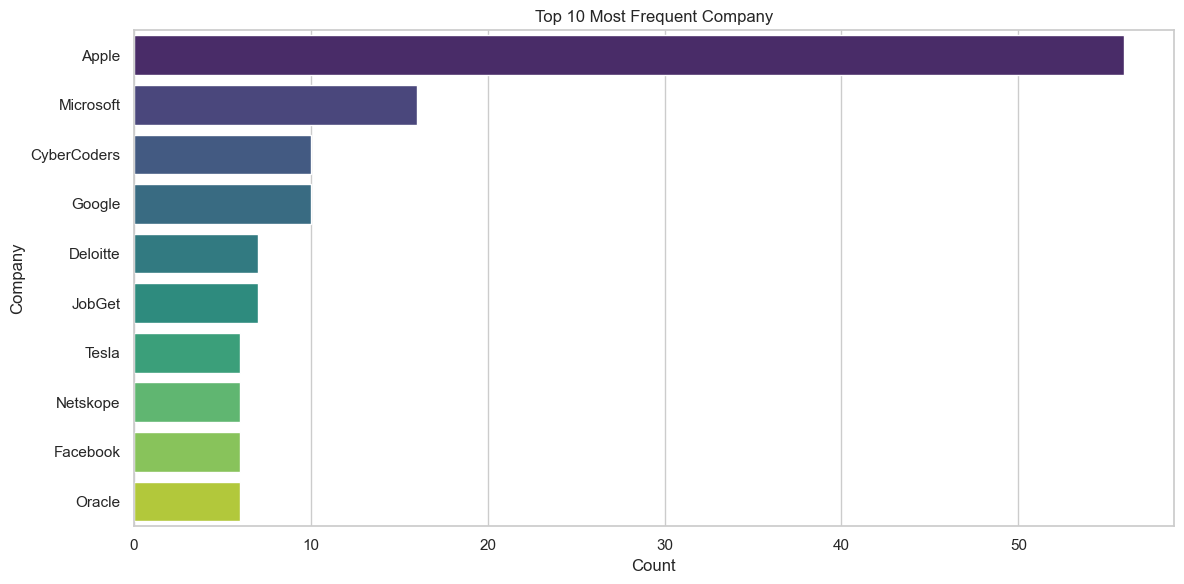

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


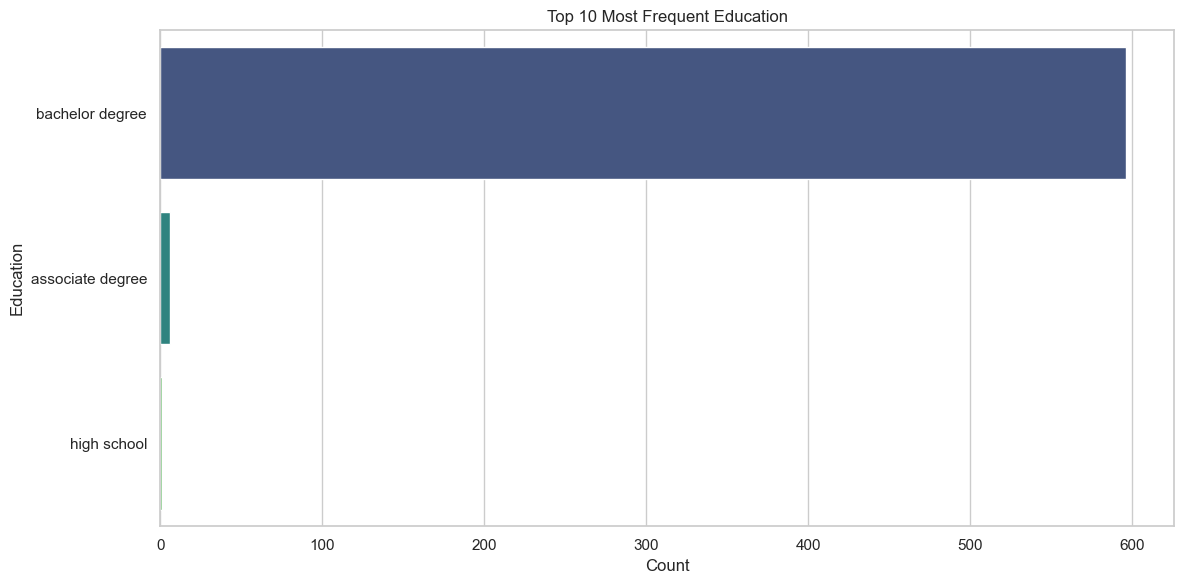

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


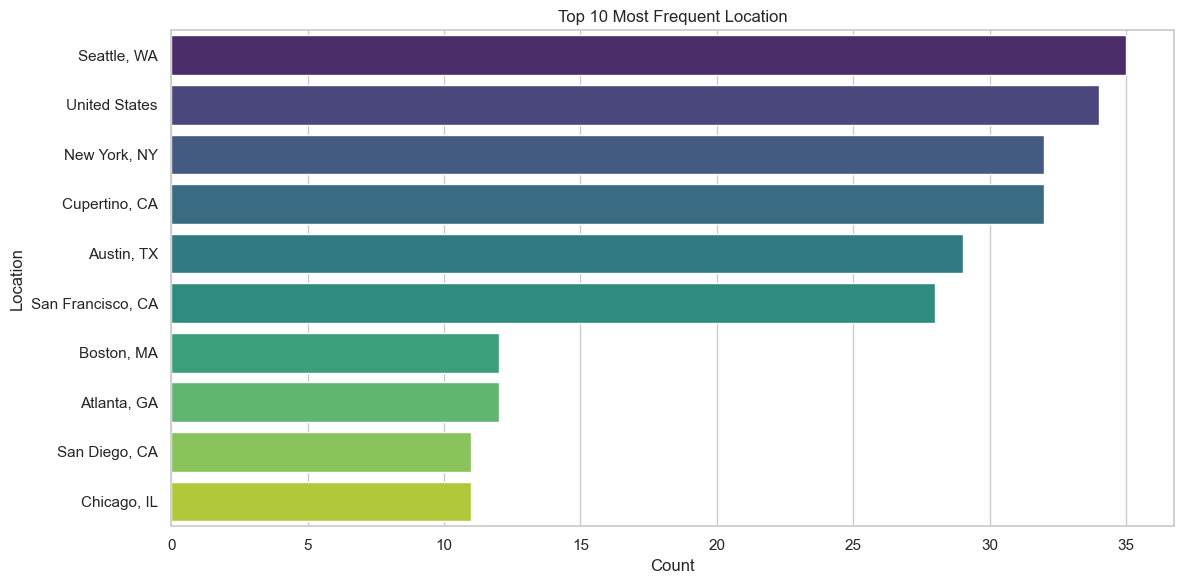

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


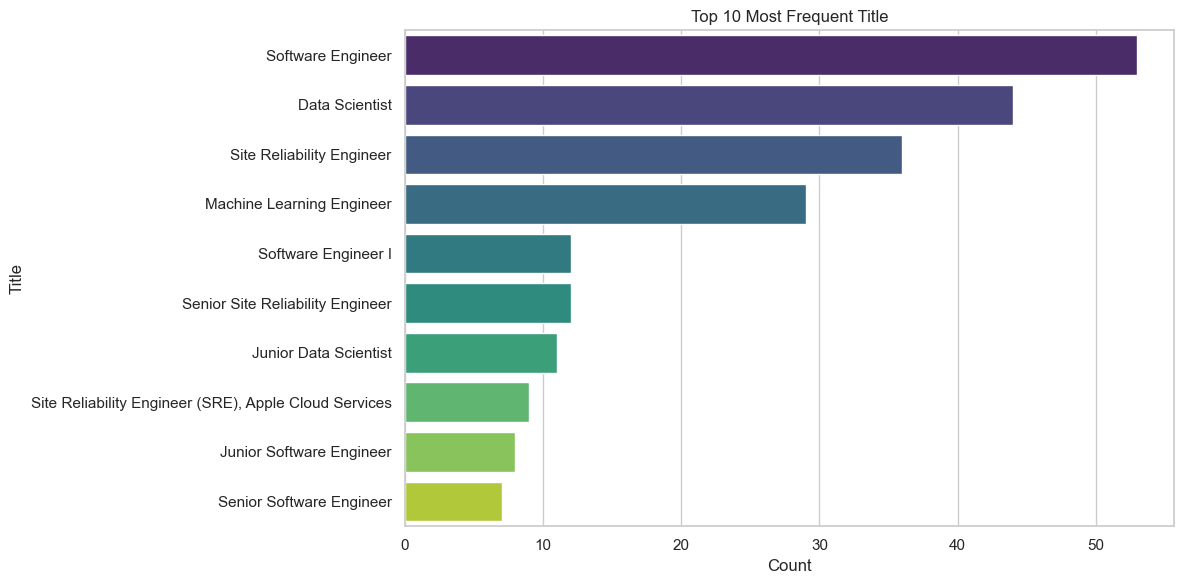

In [101]:
# List of specific categorical columns to plot
categorical_columns_to_plot = ['Job function', 'company', 'education', 'location', 'title']

# Iterate over the specified categorical columns
for col in categorical_columns_to_plot:
    if col in df_filtered_2.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(
            y=df_filtered_2[col],
            order=df_filtered_2[col].value_counts().iloc[:10].index,
            palette='viridis'
        )
        plt.title(f'Top 10 Most Frequent {col.replace("_", " ").title()}')
        plt.xlabel('Count')
        plt.ylabel(col.replace("_", " ").title())
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

In [102]:
# Create a dictionary of patterns and replacements
title_consolidation = {
    'Software Engineer': 'Software Engineer',
    'Data Scientist': 'Data Scientist',
    'Data Engineer': 'Data Engineer'
}

# Loop through the dictionary and replace job titles
for pattern, replacement in title_consolidation.items():
    df_filtered_2.loc[
        df_filtered_2['title'].str.contains(pattern, case=False, na=False),
        'title'
    ] = replacement

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2784649280.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')


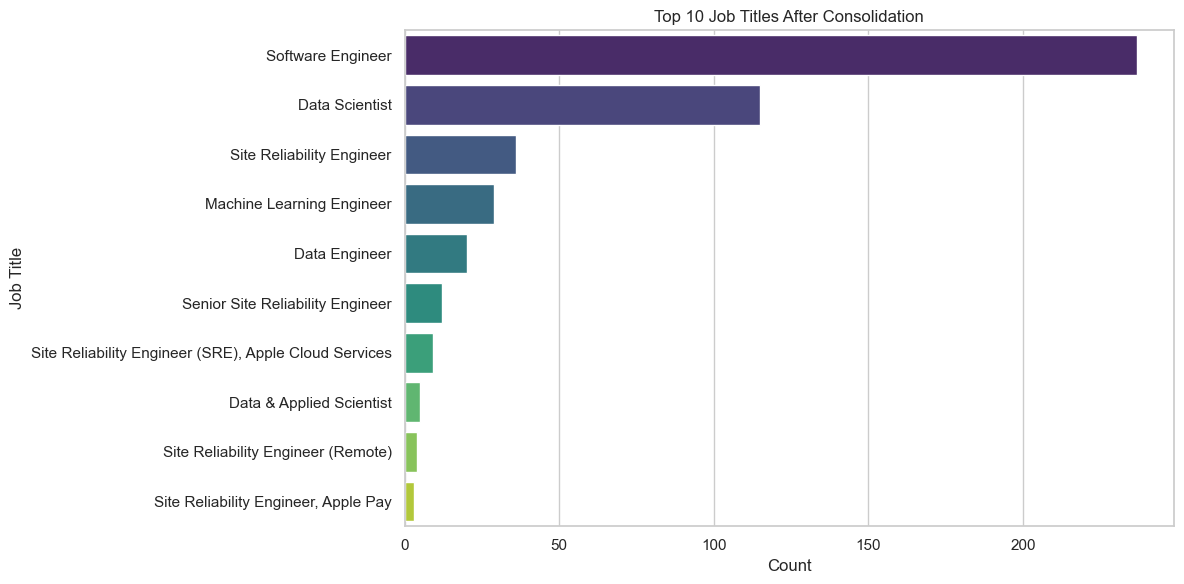

In [103]:
# Plot the top 10 job titles after consolidation
top_job_titles = df_filtered_2['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')
plt.title('Top 10 Job Titles After Consolidation')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()